# ResNet Fine-tuning: MNIST 0 vs 1 Classification
Fine-tune a pre-trained ResNet18 on MNIST digits 0 vs 1.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Data transforms - convert grayscale to RGB for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter for digits 0 and 1 only
train_indices = [i for i, (_, label) in enumerate(train_dataset) if label in [0, 1]]
test_indices = [i for i, (_, label) in enumerate(test_dataset) if label in [0, 1]]

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
test_subset = torch.utils.data.Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_subset)}, Test samples: {len(test_subset)}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.76MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 737kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.35MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 17.6MB/s]


Train samples: 12665, Test samples: 2115


In [3]:
# Load pre-trained ResNet18
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = models.resnet18(pretrained=True)

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Using device: cpu
Trainable parameters: 1,026


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [5]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

In [6]:
# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

In [7]:
# Training loop
epochs = 3
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_resnet_mnist.pth')
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, '
          f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%')

print(f'\nBest Test Accuracy: {best_acc:.2f}%')

Epoch 1: Train Loss: 0.057, Train Acc: 98.39%, Test Loss: 0.012, Test Acc: 99.72%
Epoch 2: Train Loss: 0.013, Train Acc: 99.76%, Test Loss: 0.004, Test Acc: 99.86%
Epoch 3: Train Loss: 0.009, Train Acc: 99.79%, Test Loss: 0.004, Test Acc: 99.91%

Best Test Accuracy: 99.91%


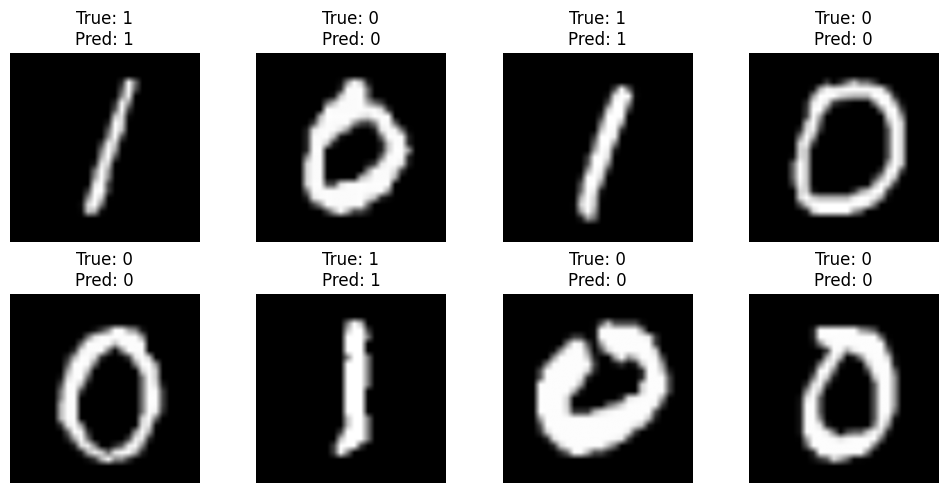

Final Test Accuracy: 99.91%


In [8]:
# Load best model and make predictions
model.load_state_dict(torch.load('best_resnet_mnist.pth'))
model.eval()

# Get test batch
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Display predictions (show only first channel since it's grayscale)
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    ax = axes[i//4, i%4]
    
    # Show grayscale image (first channel)
    img = images[i][0]  # Take first channel
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {labels[i].item()}\nPred: {predicted[i].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f'Final Test Accuracy: {best_acc:.2f}%')